## Import

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torch.distributions.normal import Normal
from torch import nn, optim  
from torch.utils.data import DataLoader, Dataset     
import torch.nn.functional as F  
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import os

from sklearn.model_selection import train_test_split

from tqdm import tqdm
import random
import copy

## Dataset

### Concave-Convex Monotonic Shift

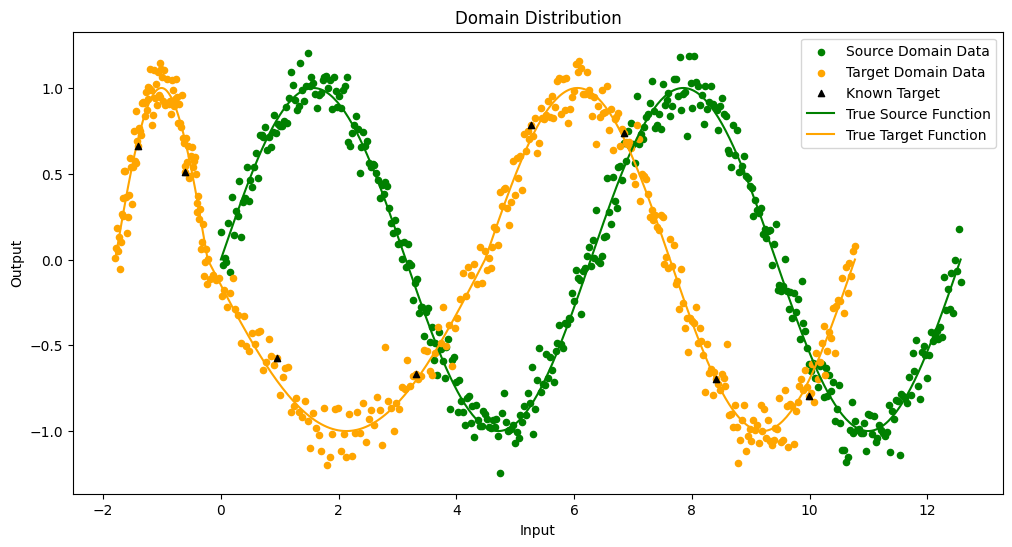

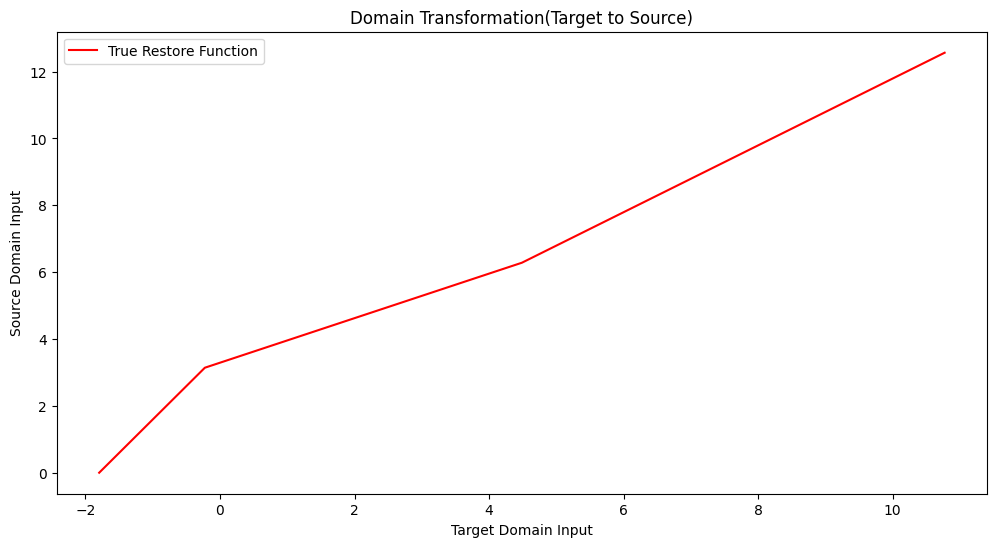

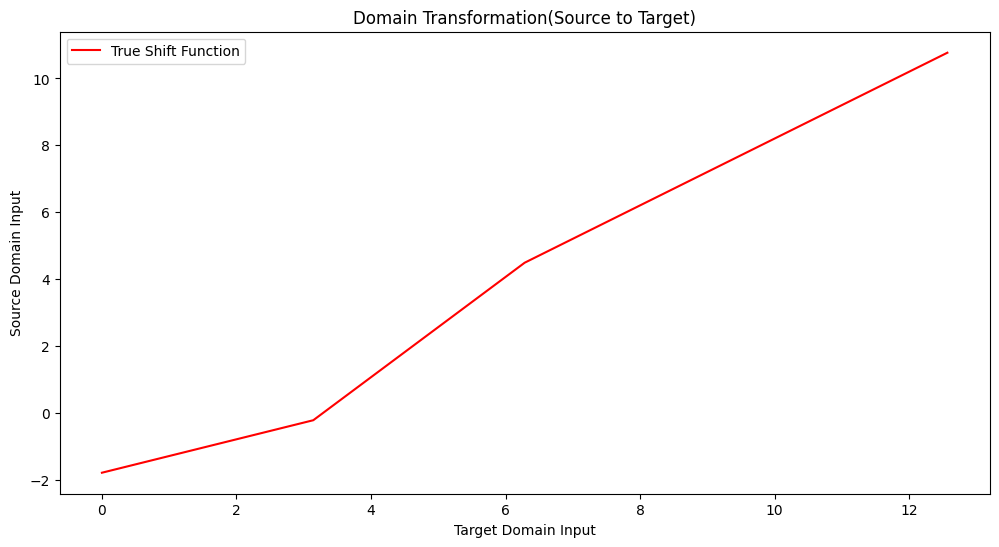

In [5]:
np.random.seed(seed=1)
# x_s = list(np.random.uniform(0,np.pi*2,100)) 
# x_t = list(np.random.uniform(0,np.pi/2,50)) + list(np.random.uniform(np.pi/2,2*np.pi,50))
#x_t_labeled = random.sample(list(np.random.uniform(0,np.pi/2,50)), bn//3) + random.sample(list(np.random.uniform(np.pi/2,2*np.pi,50)), bn//3) + random.sample(list(np.random.uniform(2*np.pi,6*np.pi,50)), bn//3) 
data_num = 401
x_s = [i*np.pi*2/100/(data_num//200) for i in range(data_num)] 
x_t = [i*np.pi/2/50/(data_num//200)-np.pi/7*4 for i in range(data_num//4)]+[i*np.pi*3/2/50/(data_num//200)+np.pi/2-np.pi/7*4 for i in range(data_num//4)]+[i*np.pi/50/(data_num//200)+np.pi*2-np.pi/7*4 for i in range(data_num//2+1)]
y_s = list(np.sin(x_s)+np.random.normal(0, 0.1, data_num))
y_s_true = list(np.sin(x_s))

y_t_true = []
for i in range(len(x_t)):
    if x_t[i]+np.pi/7*4<np.pi/2:
        y_t_true.append(np.sin(2*np.array(x_t[i]+np.pi/7*4)))
    elif x_t[i]+np.pi/7*4<np.pi*2:
        y_t_true.append(np.sin(2/3*(x_t[i]+np.pi+np.pi/7*4)))
    else:
        y_t_true.append(np.sin(1*np.array(x_t[i]-2*np.pi+np.pi/7*4)))
        
samples = np.random.normal(0, 0.1, data_num).tolist()
y_t = []
for i in range(len(x_t)):
    if x_t[i]+np.pi/7*4<np.pi/2:
        y_t.append(np.sin(2*np.array(x_t[i]+np.pi/7*4))+samples[i])
    elif x_t[i]+np.pi/7*4<np.pi*2:
        y_t.append(np.sin(2/3*(x_t[i]+np.pi+np.pi/7*4))+samples[i])
    else:
        y_t.append(np.sin(1*np.array(x_t[i]-2*np.pi+np.pi/7*4))+samples[i])

# data visualization
data_s = [[x_s[i],y_s[i],'source'] for i in range(len(x_s))]
df_s = pd.DataFrame(data_s, columns=['X','Y','domain'])
data_s_true = [[x_s[i],y_s_true[i],'source'] for i in range(len(x_s))]
df_s_true = pd.DataFrame(data_s_true, columns=['X','Y','domain'])
df_s_true = df_s_true.sort_values('X')
data_t = [[x_t[i],y_t[i],'true_target'] for i in range(len(x_t))]
df_t = pd.DataFrame(data_t, columns=['X','Y','domain'])
data_t_true = [[x_t[i],y_t_true[i],'true_target'] for i in range(len(x_t))]
df_t_true = pd.DataFrame(data_t_true, columns=['X','Y','domain'])
df_t_labeled = pd.DataFrame([[data_t[i][0],data_t[i][1],'target'] for i in range(data_num//16,data_num*15//16+1,data_num*2//16)], columns=['X','Y','domain'])
plt.figure(figsize=(12,6))

plt.scatter(df_s['X'],df_s['Y'],c='green',s=20,label='Source Domain Data', zorder=1)
plt.scatter(df_t['X'],df_t['Y'],c='orange',s=20,label='Target Domain Data', zorder=2)
plt.scatter(df_t_labeled['X'],df_t_labeled['Y'],c='black',s=20,marker='^',label='Known Target', zorder=5)
plt.plot(df_s_true['X'],df_s_true['Y'],c='green',label='True Source Function', zorder=3)
plt.plot(df_t_true['X'],df_t_true['Y'],c='orange',label='True Target Function', zorder=4)
plt.xlabel('Input')
plt.ylabel('Output')
plt.legend()
plt.title('Domain Distribution')
plt.show()


# transformation visualization
plt.figure(figsize=(12,6))
plt.plot(df_t_true['X'],df_s_true['X'],c='red',label='True Restore Function')
plt.xlabel('Target Domain Input')
plt.ylabel('Source Domain Input')
plt.legend()
plt.title('Domain Transformation(Target to Source)')

plt.show()

plt.figure(figsize=(12,6))
plt.plot(df_s_true['X'],df_t_true['X'],c='red',label='True Shift Function')
plt.xlabel('Target Domain Input')
plt.ylabel('Source Domain Input')
plt.legend()
plt.title('Domain Transformation(Source to Target)')

plt.show()

### Convex-Concave Monotonic Shift

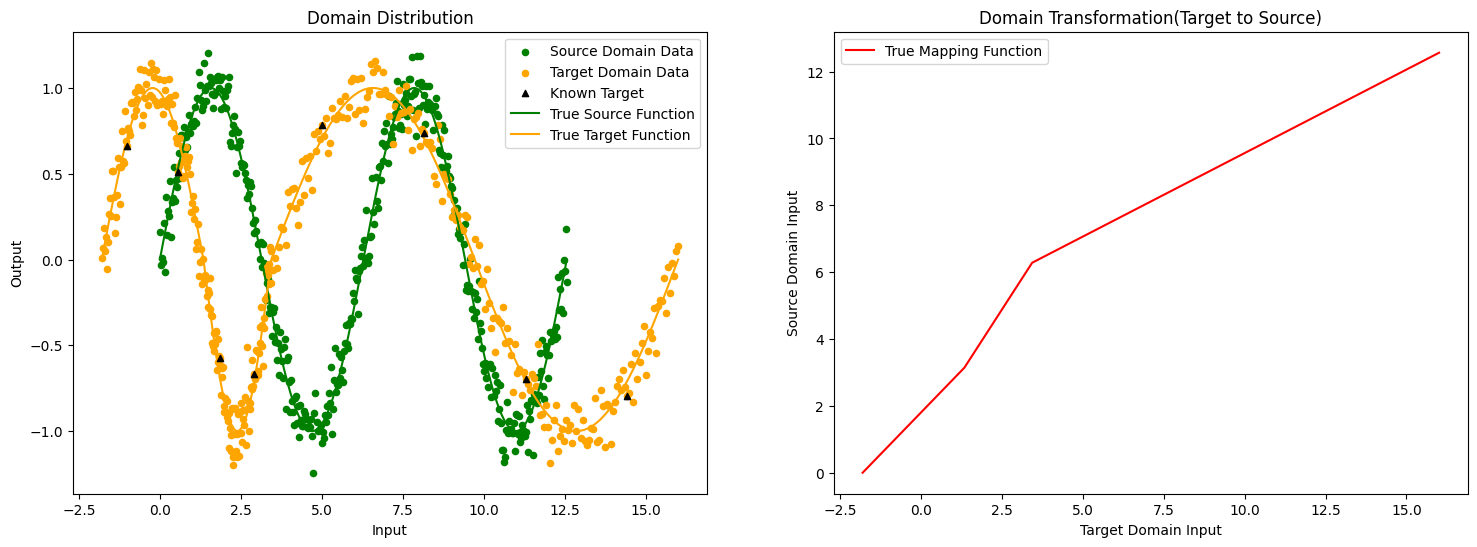

In [6]:
np.random.seed(seed=1)
# x_s = list(np.random.uniform(0,np.pi*2,100)) 
# x_t = list(np.random.uniform(0,np.pi/2,50)) + list(np.random.uniform(np.pi/2,2*np.pi,50))
#x_t_labeled = random.sample(list(np.random.uniform(0,np.pi/2,50)), bn//3) + random.sample(list(np.random.uniform(np.pi/2,2*np.pi,50)), bn//3) + random.sample(list(np.random.uniform(2*np.pi,6*np.pi,50)), bn//3) 
data_num = 401
x_s = [i*np.pi*2/100/(data_num//200) for i in range(data_num)] 
x_t = [i*np.pi/50/(data_num//200)-np.pi/7*4 for i in range(data_num//4)]+[i*np.pi*2/3/50/(data_num//200)+np.pi-np.pi/7*4 for i in range(data_num//4)]+[i*np.pi*2/50/(data_num//200)+np.pi*5/3-np.pi/7*4 for i in range(data_num//2+1)]
y_s = list(np.sin(x_s)+np.random.normal(0, 0.1, data_num))
y_s_true = list(np.sin(x_s))

y_t_true = []
for i in range(len(x_t)):
    if x_t[i]+np.pi/7*4<np.pi:
        y_t_true.append(np.sin(np.array(x_t[i]+np.pi/7*4)))
    elif x_t[i]+np.pi/7*4<np.pi*5/3:
        y_t_true.append(np.sin(3/2*(x_t[i]-1/3*np.pi+np.pi/7*4)))
    else:
        y_t_true.append(np.sin(1/2*np.array(x_t[i]-5/3*np.pi+np.pi/7*4)))
        
samples = np.random.normal(0, 0.1, data_num).tolist()
y_t = []
for i in range(len(x_t)):
    if x_t[i]+np.pi/7*4<np.pi:
        y_t.append(np.sin(np.array(x_t[i]+np.pi/7*4))+samples[i])
    elif x_t[i]+np.pi/7*4<np.pi*5/3:
        y_t.append(np.sin(3/2*(x_t[i]-1/3*np.pi+np.pi/7*4))+samples[i])
    else:
        y_t.append(np.sin(1/2*np.array(x_t[i]-5/3*np.pi+np.pi/7*4))+samples[i])

# data visualization
data_s = [[x_s[i],y_s[i],'source'] for i in range(len(x_s))]
df_s = pd.DataFrame(data_s, columns=['X','Y','domain'])
data_s_true = [[x_s[i],y_s_true[i],'source'] for i in range(len(x_s))]
df_s_true = pd.DataFrame(data_s_true, columns=['X','Y','domain'])
df_s_true = df_s_true.sort_values('X')
data_t = [[x_t[i],y_t[i],'true_target'] for i in range(len(x_t))]
df_t = pd.DataFrame(data_t, columns=['X','Y','domain'])
data_t_true = [[x_t[i],y_t_true[i],'true_target'] for i in range(len(x_t))]
df_t_true = pd.DataFrame(data_t_true, columns=['X','Y','domain'])
df_t_labeled = pd.DataFrame([[data_t[i][0],data_t[i][1],'target'] for i in range(data_num//16,data_num*15//16+1,data_num*2//16)], columns=['X','Y','domain'])
df_s.to_csv('df_s_convex_concave.csv',index=False)
df_s_true.to_csv('df_s_true_convex_concave.csv',index=False)
df_t.to_csv('df_t_convex_concave.csv',index=False)
df_t_true.to_csv('df_t_true_convex_concave.csv',index=False)
df_t_labeled.to_csv('df_t_labeled_true_convex_concave.csv',index=False)

plt.figure(figsize=(18,6))

plt.subplot(121)
plt.scatter(df_s['X'],df_s['Y'],c='green',s=20,label='Source Domain Data', zorder=1)
plt.scatter(df_t['X'],df_t['Y'],c='orange',s=20,label='Target Domain Data', zorder=2)
plt.scatter(df_t_labeled['X'],df_t_labeled['Y'],c='black',s=20,marker='^',label='Known Target', zorder=5)
plt.plot(df_s_true['X'],df_s_true['Y'],c='green',label='True Source Function', zorder=3)
plt.plot(df_t_true['X'],df_t_true['Y'],c='orange',label='True Target Function', zorder=4)
plt.xlabel('Input')
plt.ylabel('Output')
plt.legend()
plt.gca().set_title('Domain Distribution')


# transformation visualization
plt.subplot(122)
plt.plot(df_t_true['X'],df_s_true['X'],c='red',label='True Mapping Function')
plt.xlabel('Target Domain Input')
plt.ylabel('Source Domain Input')
plt.legend()
plt.gca().set_title('Domain Transformation(Target to Source)')

plt.show()

### Concave Monotonic Shift

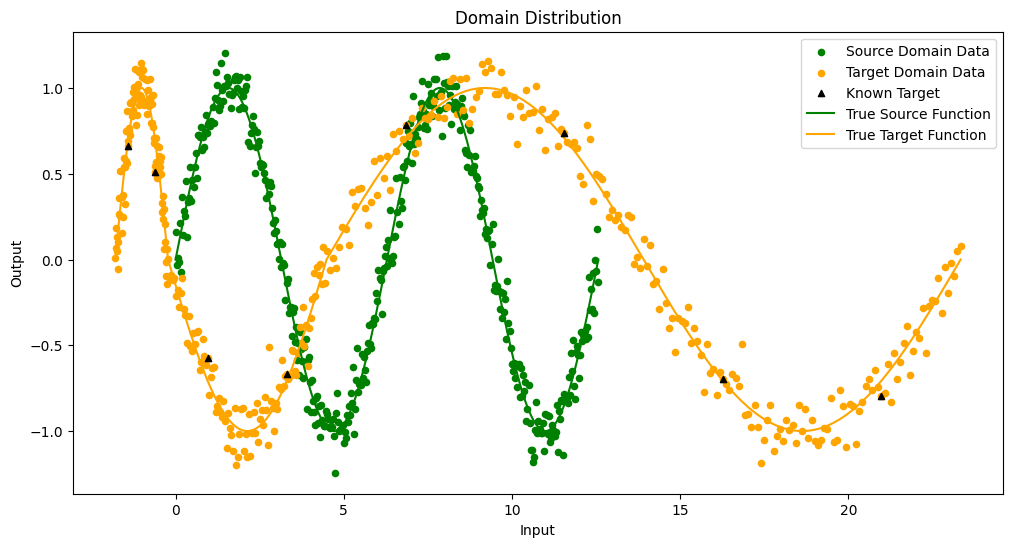

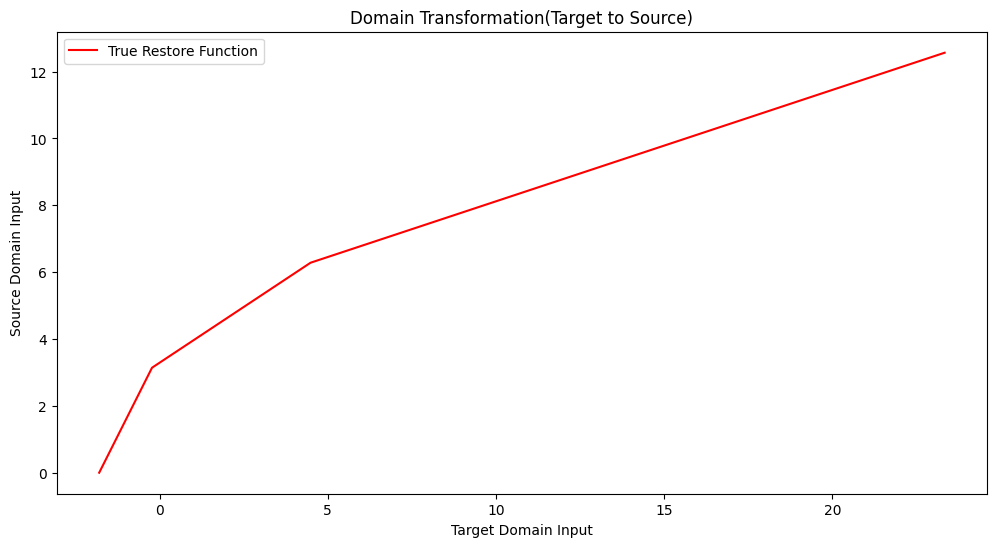

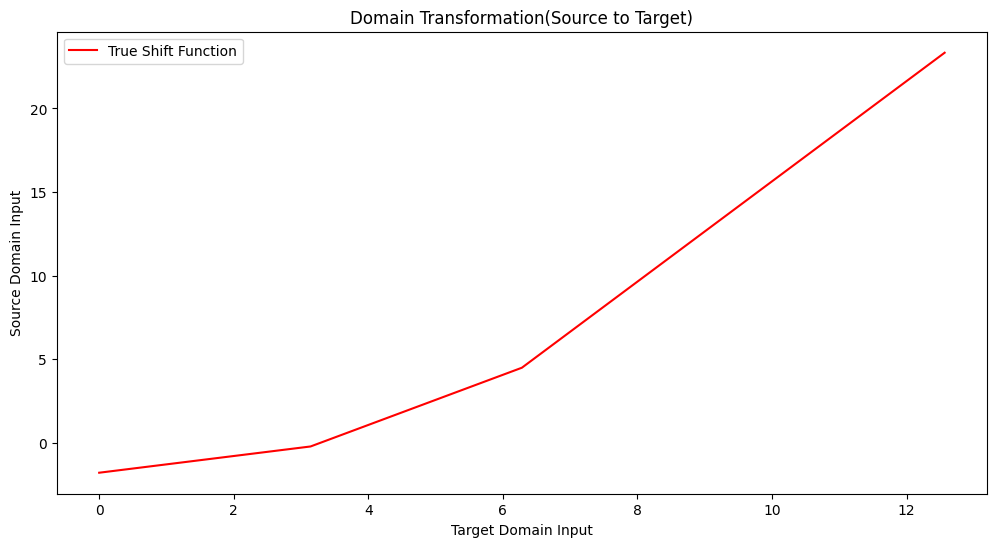

In [6]:
np.random.seed(seed=1)
# x_s = list(np.random.uniform(0,np.pi*2,100)) 
# x_t = list(np.random.uniform(0,np.pi/2,50)) + list(np.random.uniform(np.pi/2,2*np.pi,50))
#x_t_labeled = random.sample(list(np.random.uniform(0,np.pi/2,50)), bn//3) + random.sample(list(np.random.uniform(np.pi/2,2*np.pi,50)), bn//3) + random.sample(list(np.random.uniform(2*np.pi,6*np.pi,50)), bn//3) 
data_num = 401
x_s = [i*np.pi*2/100/(data_num//200) for i in range(data_num)] 
x_t = [i*np.pi/2/50/(data_num//200)-np.pi/7*4 for i in range(data_num//4)]+[i*np.pi*3/2/50/(data_num//200)+np.pi/2-np.pi/7*4 for i in range(data_num//4)]+[i*np.pi*3/50/(data_num//200)+np.pi*2-np.pi/7*4 for i in range(data_num//2+1)]
y_s = list(np.sin(x_s)+np.random.normal(0, 0.1, data_num))
y_s_true = list(np.sin(x_s))

y_t_true = []
for i in range(len(x_t)):
    if x_t[i]+np.pi/7*4<np.pi/2:
        y_t_true.append(np.sin(2*np.array(x_t[i]+np.pi/7*4)))
    elif x_t[i]+np.pi/7*4<np.pi*2:
        y_t_true.append(np.sin(2/3*(x_t[i]+np.pi+np.pi/7*4)))
    else:
        y_t_true.append(np.sin(1/3*np.array(x_t[i]-2*np.pi+np.pi/7*4)))
        
samples = np.random.normal(0, 0.1, data_num).tolist()
y_t = []
for i in range(len(x_t)):
    if x_t[i]+np.pi/7*4<np.pi/2:
        y_t.append(np.sin(2*np.array(x_t[i]+np.pi/7*4))+samples[i])
    elif x_t[i]+np.pi/7*4<np.pi*2:
        y_t.append(np.sin(2/3*(x_t[i]+np.pi+np.pi/7*4))+samples[i])
    else:
        y_t.append(np.sin(1/3*np.array(x_t[i]-2*np.pi+np.pi/7*4))+samples[i])

# data visualization
data_s = [[x_s[i],y_s[i],'source'] for i in range(len(x_s))]
df_s = pd.DataFrame(data_s, columns=['X','Y','domain'])
data_s_true = [[x_s[i],y_s_true[i],'source'] for i in range(len(x_s))]
df_s_true = pd.DataFrame(data_s_true, columns=['X','Y','domain'])
df_s_true = df_s_true.sort_values('X')
data_t = [[x_t[i],y_t[i],'true_target'] for i in range(len(x_t))]
df_t = pd.DataFrame(data_t, columns=['X','Y','domain'])
data_t_true = [[x_t[i],y_t_true[i],'true_target'] for i in range(len(x_t))]
df_t_true = pd.DataFrame(data_t_true, columns=['X','Y','domain'])
df_t_labeled = pd.DataFrame([[data_t[i][0],data_t[i][1],'target'] for i in range(data_num//16,data_num*15//16+1,data_num*2//16)], columns=['X','Y','domain'])


plt.figure(figsize=(12,6))

plt.scatter(df_s['X'],df_s['Y'],c='green',s=20,label='Source Domain Data', zorder=1)
plt.scatter(df_t['X'],df_t['Y'],c='orange',s=20,label='Target Domain Data', zorder=2)
plt.scatter(df_t_labeled['X'],df_t_labeled['Y'],c='black',s=20,marker='^',label='Known Target', zorder=5)
plt.plot(df_s_true['X'],df_s_true['Y'],c='green',label='True Source Function', zorder=3)
plt.plot(df_t_true['X'],df_t_true['Y'],c='orange',label='True Target Function', zorder=4)
plt.xlabel('Input')
plt.ylabel('Output')
plt.legend()
plt.title('Domain Distribution')
plt.show()


# transformation visualization
plt.figure(figsize=(12,6))
plt.plot(df_t_true['X'],df_s_true['X'],c='red',label='True Restore Function')
plt.xlabel('Target Domain Input')
plt.ylabel('Source Domain Input')
plt.legend()
plt.title('Domain Transformation(Target to Source)')

plt.show()

plt.figure(figsize=(12,6))
plt.plot(df_s_true['X'],df_t_true['X'],c='red',label='True Shift Function')
plt.xlabel('Target Domain Input')
plt.ylabel('Source Domain Input')
plt.legend()
plt.title('Domain Transformation(Source to Target)')

plt.show()

### Convex Monotonic Shift

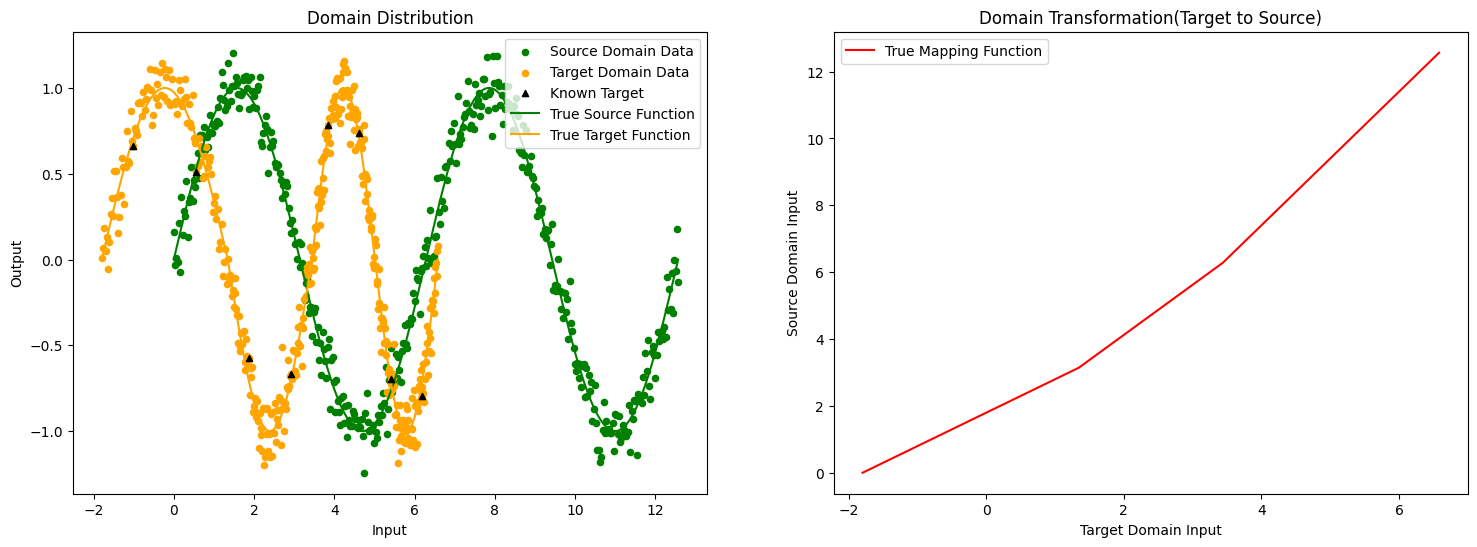

In [8]:
np.random.seed(seed=1)
# x_s = list(np.random.uniform(0,np.pi*2,100)) 
# x_t = list(np.random.uniform(0,np.pi/2,50)) + list(np.random.uniform(np.pi/2,2*np.pi,50))
#x_t_labeled = random.sample(list(np.random.uniform(0,np.pi/2,50)), bn//3) + random.sample(list(np.random.uniform(np.pi/2,2*np.pi,50)), bn//3) + random.sample(list(np.random.uniform(2*np.pi,6*np.pi,50)), bn//3) 
data_num = 401
x_s = [i*np.pi*2/100/(data_num//200) for i in range(data_num)] 
x_t = [i*np.pi/50/(data_num//200)-np.pi/7*4 for i in range(data_num//4)]+[i*np.pi*2/3/50/(data_num//200)+np.pi-np.pi/7*4 for i in range(data_num//4)]+[i*np.pi/2/50/(data_num//200)+np.pi*5/3-np.pi/7*4 for i in range(data_num//2+1)]
y_s = list(np.sin(x_s)+np.random.normal(0, 0.1, data_num))
y_s_true = list(np.sin(x_s))

y_t_true = []
for i in range(len(x_t)):
    if x_t[i]+np.pi/7*4<np.pi:
        y_t_true.append(np.sin(np.array(x_t[i]+np.pi/7*4)))
    elif x_t[i]+np.pi/7*4<np.pi*5/3:
        y_t_true.append(np.sin(3/2*(x_t[i]-1/3*np.pi+np.pi/7*4)))
    else:
        y_t_true.append(np.sin(2*np.array(x_t[i]-5/3*np.pi+np.pi/7*4)))
        
samples = np.random.normal(0, 0.1, data_num).tolist()
y_t = []
for i in range(len(x_t)):
    if x_t[i]+np.pi/7*4<np.pi:
        y_t.append(np.sin(np.array(x_t[i]+np.pi/7*4))+samples[i])
    elif x_t[i]+np.pi/7*4<np.pi*5/3:
        y_t.append(np.sin(3/2*(x_t[i]-1/3*np.pi+np.pi/7*4))+samples[i])
    else:
        y_t.append(np.sin(2*np.array(x_t[i]-5/3*np.pi+np.pi/7*4))+samples[i])

# data visualization
data_s = [[x_s[i],y_s[i],'source'] for i in range(len(x_s))]
df_s = pd.DataFrame(data_s, columns=['X','Y','domain'])
data_s_true = [[x_s[i],y_s_true[i],'source'] for i in range(len(x_s))]
df_s_true = pd.DataFrame(data_s_true, columns=['X','Y','domain'])
df_s_true = df_s_true.sort_values('X')
data_t = [[x_t[i],y_t[i],'true_target'] for i in range(len(x_t))]
df_t = pd.DataFrame(data_t, columns=['X','Y','domain'])
data_t_true = [[x_t[i],y_t_true[i],'true_target'] for i in range(len(x_t))]
df_t_true = pd.DataFrame(data_t_true, columns=['X','Y','domain'])
df_t_labeled = pd.DataFrame([[data_t[i][0],data_t[i][1],'target'] for i in range(data_num//16,data_num*15//16+1,data_num*2//16)], columns=['X','Y','domain'])
df_s.to_csv('df_s_convex.csv',index=False)
df_s_true.to_csv('df_s_true_convex.csv',index=False)
df_t.to_csv('df_t_convex.csv',index=False)
df_t_true.to_csv('df_t_true_convex.csv',index=False)
df_t_labeled.to_csv('df_t_labeled_true_convex.csv',index=False)

plt.figure(figsize=(18,6))

plt.subplot(121)
plt.scatter(df_s['X'],df_s['Y'],c='green',s=20,label='Source Domain Data', zorder=1)
plt.scatter(df_t['X'],df_t['Y'],c='orange',s=20,label='Target Domain Data', zorder=2)
plt.scatter(df_t_labeled['X'],df_t_labeled['Y'],c='black',s=20,marker='^',label='Known Target', zorder=5)
plt.plot(df_s_true['X'],df_s_true['Y'],c='green',label='True Source Function', zorder=3)
plt.plot(df_t_true['X'],df_t_true['Y'],c='orange',label='True Target Function', zorder=4)
plt.xlabel('Input')
plt.ylabel('Output')
plt.legend()
plt.gca().set_title('Domain Distribution')


# transformation visualization
plt.subplot(122)
plt.plot(df_t_true['X'],df_s_true['X'],c='red',label='True Mapping Function')
plt.xlabel('Target Domain Input')
plt.ylabel('Source Domain Input')
plt.legend()
plt.gca().set_title('Domain Transformation(Target to Source)')

plt.show()